Tutorial 2: Mappers
===================

In the previous tutorial, we used a pixelization to create made a `Mapper`. However, it was not clear what a `Mapper`
does, why it was called a mapper and whether it was mapping anything at all!

Therefore, in this tutorial, we'll cover mappers in more detail.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use new strong lensing data, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

Now, lets set up our `Grid2D` (using the image above).

In [3]:
grid = al.Grid2D.uniform(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales
)

Our `Tracer` will use the same lens galaxy and source galaxy that we used to Simulate the imaging data (although, 
becuase we're modeling the source with a pixel-grid, we do not pass it any light profiles.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=grid)[1]

__Mappers__

We now setup a `Pixelization` and use it to create a `Mapper` via the tracer`s source-plane grid, just like we did in
the previous tutorial.

In [5]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

We now plot the `Mapper` alongside the image we used to generate the source-plane grid.

Using the `Visuals2D` object we are also going to highlight specific grid coordinates certain colors, such that we
can see how they map from the image-plane to source-plane and visa versa.

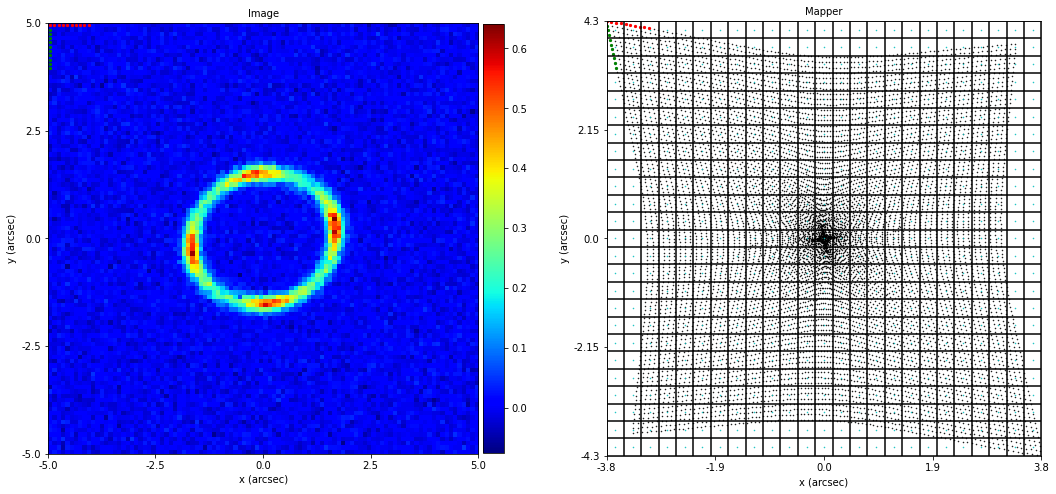

In [6]:
visuals_2d = aplt.Visuals2D(
    indexes=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    ]
)
include_2d = aplt.Include2D(mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

Using a mapper, we can now make these mappings appear the other way round. That is, we can input a source-pixel
index (of our rectangular grid) and highlight how all of the image-pixels that it contains map to the image-plane. 

Lets map source pixel 313, the central source-pixel, to the image.

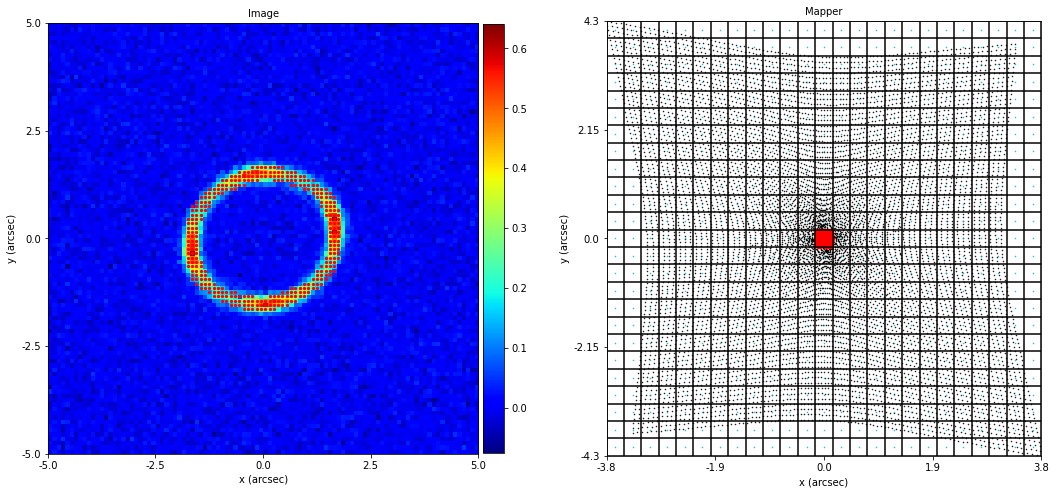

In [7]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

There we have it, multiple imaging in all its glory. Try changing the source-pixel indexes of the line below. This 
will give you a feel for how different regions of the source-plane map to the image.

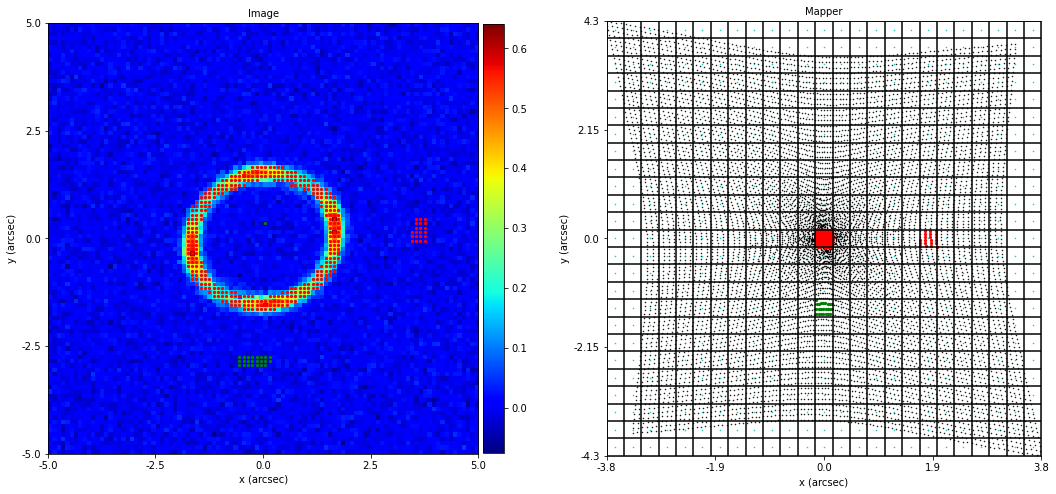

In [8]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312, 318], [412]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

Okay, so I think we can agree, mapper's map things! More specifically, they map source-plane pixels to multiple pixels 
in the observed image of a strong lens.

__Masking__

Finally, lets repeat the steps that we performed above, but now using a masked image. By applying a `Mask2D`, the 
mapper only maps image-pixels that are not removed by the mask. This removes the (many) image pixels at the edge of the 
image, where the source is not present. These pixels also pad-out the source-plane, thus by removing them our 
source-plane reduces in size.

Lets just have a quick look at these edges pixels:

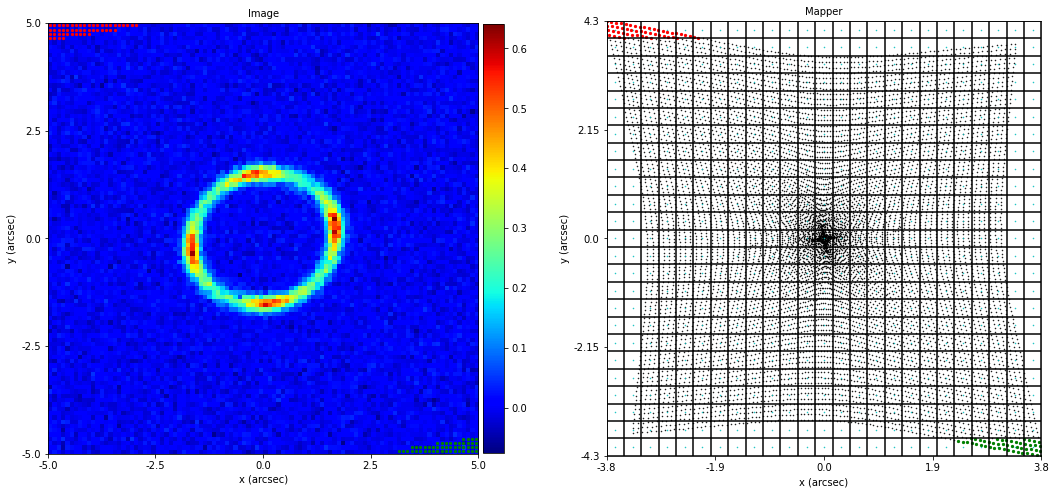

In [9]:
visuals_2d = aplt.Visuals2D(
    pixelization_indexes=[[0, 1, 2, 3, 4, 5, 6, 7], [620, 621, 622, 623, 624]]
)
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

Lets use an annular `Mask2D`, which will capture the ring-like shape of the lensed source galaxy.

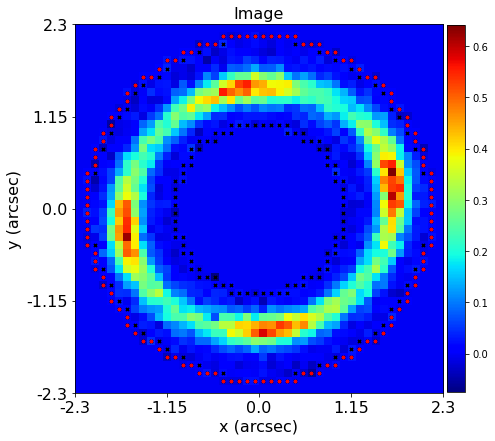

In [10]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.0,
    outer_radius=2.2,
)

imaging = imaging.apply_mask(mask=mask)
imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures_2d(image=True)

To create the mapper, we need to set up the masked imaging's grid as the source-plane gird via the tracer.

In [11]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=imaging.grid)[1]

We can now use the masked source-plane grid to create a new `Mapper` (using the same rectangular 25 x 25 pixelization 
as before).

In [12]:
mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

Lets plot it.

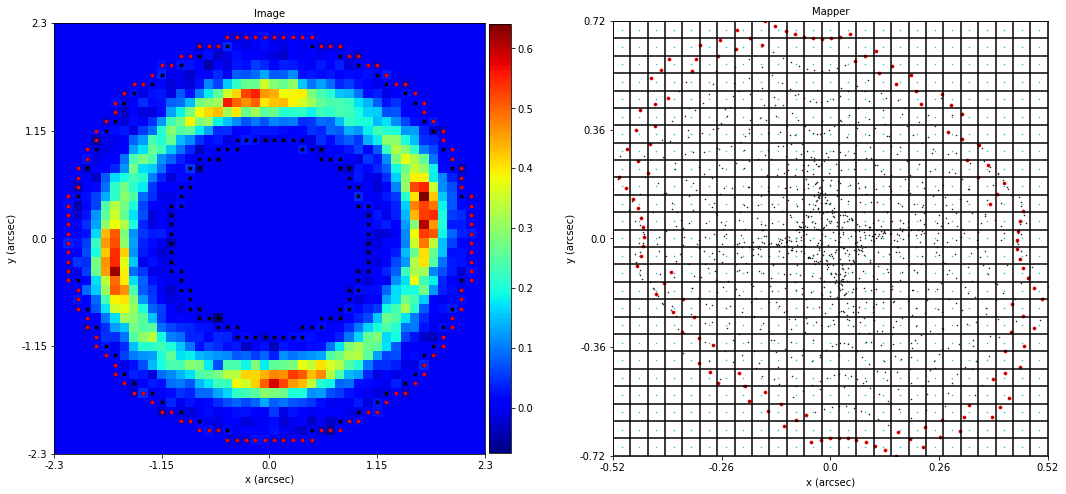

In [13]:
include_2d = aplt.Include2D(mask=True, mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(mapper=mapper, include_2d=include_2d)
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

First, look how much closer we are to the source-plane (The axis sizes have decreased from ~ -2.5" -> 2.5" to 
~ -0.6" to 0.6"). We can more clearly see the diamond of points in the centre of the source-plane (for those who have 
been reading up, this diamond is called the `caustic`).

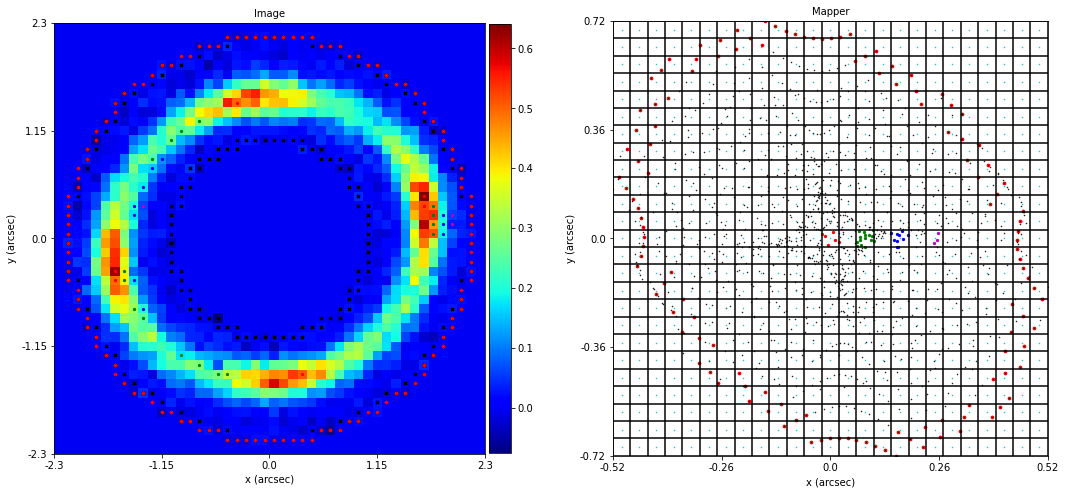

In [14]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312], [314], [316], [318]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

__Wrap Up__

In this tutorial, we learnt about mappers, and we used them to understand how the image and source plane map to one 
another. Your exercises are:

 1) Change the einstein radius of the lens galaxy in small increments (e.g. einstein radius 1.6" -> 1.55"). As the 
 radius deviates from 1.6" (the input value of the simulated lens), what do you notice about where the points map 
 from the centre of the source-plane (where the source-galaxy is simulated, e.g. (0.0", 0.0"))?
        
 2) Think about how this could help us actually model lenses. We have said we're going to reconstruct our source 
 galaxies on the pixel-grid. So, how does knowing how each pixel maps to the image actually help us? If you`ve not got 
 any bright ideas, then worry not, that exactly what we're going to cover in the next tutorial.